In [1]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import os, sys
import json

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
#sys.path.extend(['/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/arnie', '/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/'])
#os.environ["ARNIEFILE"] = '/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/arnie/run.arnie'
#sys.path.append('/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/DegScore')

sys.path.append('..')
import assign_loop_type
from assign_loop_type import write_loop_assignments


from DegScore import DegScore
from arnie.sample_structures import sample_structures

from tqdm.notebook import tqdm

## Code to reproduce DegScore from Kaggle datasets

In [3]:
def get_ensemble(sequence, n=1000):
    structs = sample_structures(sequence, n_samples=n, package='vienna')
    structs = [list(write_loop_assignments(s)) for s in structs]
    return np.array(structs)

def encode_input(df, window_size=1, pad=10, seq=True, struct=True, ensemble_size=0):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    seq (bool): include sequence encoding
    struct (bool): include bpRNA structure encoding
    
    Outputs:
    Input array (n_samples x n_features): array of windowed input features
    feature_names (list): feature names
    
    '''
    #MAX_LEN = 68
    BASES = ['A','U','G','C']
    STRUCTS = ['H','E','I','M','B','S']
    
    inpts = []
    labels = []

    feature_kernel=[]
    if seq:
        feature_kernel.extend(BASES)
    if struct:
        feature_kernel.extend(STRUCTS)

    feature_names = ['%s_%d' % (k, val) for val in range(-1*window_size, window_size+1) for k in feature_kernel]
    
    for i, row in tqdm(df.iterrows(), desc='Encoding inputs', total=len(df)):
        MAX_LEN = len(row['sequence'])-39 #68 for RYOS-I
        
        arr = np.zeros([MAX_LEN,len(feature_kernel)])
        
        if ensemble_size > 0: # stochastically sample ensemble
            ensemble = get_ensemble(row['sequence'], n=ensemble_size)
        else: # use MEA structure
            ensemble = np.array([list(row['predicted_loop_type'])])

        for index in range(pad,MAX_LEN):
            ctr=0

            #encode sequence
            if seq:
                for char in BASES:
                    if row['sequence'][index]==char:
                        arr[index,ctr]+=1
                    ctr+=1

            if struct:
                loop_assignments = ''.join(ensemble[:,index])
                for char in STRUCTS:
                    prob = loop_assignments.count(char) / len(loop_assignments)
                    arr[index,ctr]+=prob
                    ctr+=1
                    
        # add zero padding to the side
        padded_arr = np.vstack([np.zeros([window_size,len(feature_kernel)]),arr[pad:], np.zeros([window_size,len(feature_kernel)])])

        for index in range(pad,MAX_LEN):
            new_index = index+window_size-pad
            tmp = padded_arr[new_index-window_size:new_index+window_size+1]
            inpts.append(tmp.flatten())
            labels.append('%s_%d' % (row['id'], index))
            
    return np.array(inpts), feature_names, labels

def encode_output(df, data_type='reactivity', pad=10):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    data_type: column name for degradation
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    
    Outputs:
    output array (n_samples): array of reactivity values
    
    '''
    #MAX_LEN = 68
    
    outpts = []
    labels = []
    # output identity should be in form id_00073f8be_0

    for i, row in df.iterrows():
        MAX_LEN = len(row['sequence'])-39
        
        for index in range(pad,MAX_LEN):
            outpts.append(row[data_type][index])
            labels.append('%s_%d' % (row['id'], index))
            
            
    return outpts, labels

In [80]:
def encode_input_construct(df, window_size=1, pad=10, seq=True, struct=True, ensemble_size=0):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    seq (bool): include sequence encoding
    struct (bool): include bpRNA structure encoding
    
    Outputs:
    Input array (n_samples x n_features): array of windowed input features
    feature_names (list): feature names
    
    '''
    #MAX_LEN = 68
    BASES = ['A','U','G','C']
    STRUCTS = ['H','E','I','M','B','S']
    
    inpts = []
    labels = []

    feature_kernel=[]
    if seq:
        feature_kernel.extend(BASES)
    if struct:
        feature_kernel.extend(STRUCTS)

    feature_names = ['%s_%d' % (k, val) for val in range(-1*window_size, window_size+1) for k in feature_kernel]
    
    for i, row in tqdm(df.iterrows(), desc='Encoding inputs', total=len(df)):
        MAX_LEN = len(row['sequence'])-39 #68 for RYOS-I
        
        arr = np.zeros([MAX_LEN,len(feature_kernel)])
        
        if ensemble_size > 0: # stochastically sample ensemble
            ensemble = get_ensemble(row['sequence'], n=ensemble_size)
        else: # use MEA structure
            ensemble = np.array([list(row['predicted_loop_type'])])

        for index in range(pad,MAX_LEN):
            ctr=0

            #encode sequence
            if seq:
                for char in BASES:
                    if row['sequence'][index]==char:
                        arr[index,ctr]+=1
                    ctr+=1

            if struct:
                loop_assignments = ''.join(ensemble[:,index])
                for char in STRUCTS:
                    prob = loop_assignments.count(char) / len(loop_assignments)
                    arr[index,ctr]+=prob
                    ctr+=1
                    
        # add zero padding to the side
        padded_arr = np.vstack([np.zeros([window_size,len(feature_kernel)]),arr[pad:], np.zeros([window_size,len(feature_kernel)])])

        tmp_construct_holder = np.zeros((window_size*2+1)*len(feature_kernel))
        
        for index in range(pad,MAX_LEN):
            new_index = index+window_size-pad
            tmp = padded_arr[new_index-window_size:new_index+window_size+1]
                        
            tmp_construct_holder = tmp_construct_holder+tmp.flatten()
            labels.append('%s_%d' % (row['id'], index))
            
        inpts.append(tmp_construct_holder)

    return np.array(inpts), feature_names, labels

def encode_output_construct(df, data_type='reactivity', pad=10):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    data_type: column name for degradation
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    
    Outputs:
    output array (n_samples): array of reactivity values
    
    '''
    #MAX_LEN = 68
    
    outpts = []
    labels = []
    # output identity should be in form id_00073f8be_0

    for i, row in df.iterrows():
        MAX_LEN = len(row['sequence'])-39
        outpts.append(np.sum([row[data_type][index] for index in range(pad,MAX_LEN)]))
            
    return outpts, labels

#### Load data 

In [81]:
kaggle_train = pd.read_json('train.json',lines=True)
kaggle_train = kaggle_train.loc[kaggle_train['SN_filter']==1]

kaggle_test = pd.read_json('test.json',lines=True)
#kaggle_test = pd.read_csv('test_labels.csv')

#### Encode data

###### Max. expected accuracy

In [95]:
mea_inputs_train, mea_feature_names, _ = encode_input(kaggle_train, window_size=2)
mea_inputs_test, _, mea_test_labels = encode_input(kaggle_test, window_size=2)

In [82]:
mea_inputs_train_construct, mea_feature_names, _ = encode_input_construct(kaggle_train, window_size=12)
#mea_inputs_test, _, mea_test_labels = encode_input(kaggle_test, window_size=12)

###### Ensemble-averaged encoding

In [56]:
ensemble_size = 100
ens_inputs_train, ens_feature_names, _ = encode_input(kaggle_train, window_size=12, ensemble_size=ensemble_size)
ens_inputs_test, _, ens_test_labels = encode_input(kaggle_test, window_size=12, ensemble_size=ensemble_size)

#### Visualize two encodings for an example nucleotide

Text(0.5, 0, 'window position')

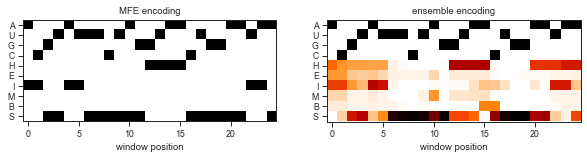

In [76]:
figure(figsize=(10,4))
subplot(1,2,1)
title('MFE encoding')
imshow(np.array(mea_inputs_train[33].reshape(25,10)).T,cmap='gist_heat_r')
yticks(range(10), ['A','U','G','C','H','E','I','M','B','S'])
xlabel('window position')
subplot(1,2,2)
title('ensemble encoding')
imshow(np.array(ens_inputs_train[33].reshape(25,10)).T,cmap='gist_heat_r')
yticks(range(10), ['A','U','G','C','H','E','I','M','B','S'])
xlabel('window position')

#### Setup kaggle submissions

In [57]:
sample_submission = pd.read_csv('sample_submission.csv.zip')
mask = sample_submission['id_seqpos'].isin(mea_test_labels)

In [58]:
ens_sample_submission = pd.read_csv('sample_submission.csv.zip')
mask = ens_sample_submission['id_seqpos'].isin(ens_test_labels)

#### Train models

###### MEA models

In [96]:
mea_models = {}

for output_type in ['deg_Mg_pH10']: #['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C','deg_50C']:
    mea_outputs_train, mea_outputs_labels = encode_output(kaggle_train, data_type=output_type)
    #mea_outputs_train, mea_outputs_labels = encode_output_construct(kaggle_train, data_type=output_type)

    # Clip negative values to 0
    #mea_outputs_train = np.clip(mea_outputs_train, -1, 100)

    reg = Ridge(alpha=0.15, fit_intercept=False)
    print('Fitting %s ...' % output_type)
    #reg.fit(mea_inputs_train_construct, mea_outputs_train)
    reg.fit(mea_inputs_train, mea_outputs_train)
    
    mea_models[output_type] = reg
    
    # test inputs, add to sample submission df
    test_prediction = reg.predict(mea_inputs_test)
    #sample_submission.loc[mask, output_type] = test_prediction

Fitting deg_Mg_pH10 ...


In [97]:
','.join(["%.6f" % x for x in reg.coef_])


'-0.119975,-0.109280,-0.125776,-0.129901,0.137878,0.048720,0.129931,0.079754,0.123292,0.098688,-0.005116,0.035615,-0.031198,-0.061845,0.049366,-0.030215,0.016736,0.018498,0.016610,-0.034317,0.859800,0.932746,0.916964,0.827843,-0.068651,-0.063083,-0.145654,0.010412,0.059719,-0.278208,-0.068793,0.232126,-0.258597,-0.231803,-0.074957,-0.083229,-0.013723,0.007611,0.069522,-0.082664,0.046571,0.009784,-0.087292,-0.024710,-0.015972,-0.188900,-0.002574,-0.002828,0.009722,-0.080645'

In [99]:
mdl = DegScore('AAA')

In [101]:
mdl.__dict__

{'sequence': 'AAA',
 'structure': '...',
 'bprna_string': 'EEE',
 'coeffs_': [-0.02,
  -0.027,
  -0.026,
  -0.017,
  0.005,
  0.0,
  0.005,
  -0.006,
  -0.011,
  0.006,
  0.031,
  0.021,
  0.036,
  0.034,
  0.026,
  -0.024,
  -0.005,
  0.028,
  -0.022,
  -0.015,
  -0.043,
  -0.043,
  -0.029,
  -0.026,
  0.016,
  -0.077,
  -0.001,
  -0.016,
  0.031,
  -0.001,
  0.064,
  0.065,
  0.064,
  0.069,
  0.029,
  0.044,
  -0.003,
  0.012,
  -0.006,
  -0.004,
  -0.072,
  -0.066,
  -0.061,
  -0.065,
  0.014,
  0.037,
  0.051,
  0.017,
  0.054,
  0.037,
  -0.065,
  -0.068,
  -0.058,
  -0.041,
  -0.014,
  0.075,
  -0.007,
  0.005,
  -0.01,
  -0.006,
  0.009,
  0.014,
  0.019,
  0.037,
  0.005,
  -0.097,
  0.013,
  -0.005,
  0.001,
  0.002,
  -0.026,
  -0.026,
  -0.036,
  -0.008,
  0.041,
  0.067,
  0.017,
  0.007,
  0.034,
  0.028,
  -0.077,
  -0.079,
  -0.092,
  -0.064,
  0.012,
  0.022,
  0.041,
  0.041,
  0.057,
  0.038,
  0.01,
  0.017,
  -0.004,
  0.05,
  -0.018,
  -0.144,
  -0.001,
  0.009,
 

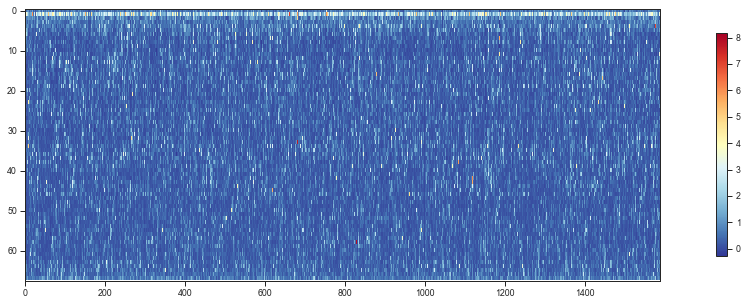

In [94]:
figure(figsize=(20,5))
imshow(np.vstack([x[:68] for x in kaggle_train['deg_Mg_pH10']]).T, aspect=10,cmap='RdYlBu_r')
colorbar(fraction=0.01)

###### Ensemble-averaged models

In [60]:
ens_models = {}

for output_type in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C','deg_50C']:
    ens_outputs_train, ens_outputs_labels = encode_output(kaggle_train, data_type=output_type)
    
    # Clip negative values to 0
    ens_outputs_train = np.clip(ens_outputs_train, 0, 100)

    reg = Ridge(alpha=0.15)
    print('Fitting %s ...' % output_type)
    reg.fit(ens_inputs_train, ens_outputs_train)
    
    ens_models[output_type] = reg
    
    # test inputs, add to sample submission df
    test_prediction = reg.predict(ens_inputs_test)
    ens_sample_submission.loc[mask, output_type] = test_prediction

Fitting reactivity ...
Fitting deg_Mg_pH10 ...
Fitting deg_pH10 ...
Fitting deg_Mg_50C ...
Fitting deg_50C ...


In [61]:
# save to csv
sample_submission.to_csv('test_mea_code_jan28.csv', index=False)
ens_sample_submission.to_csv('test_ens_code_jan28.csv', index=False)

## Using the existing class that contains "DegScore-2.1"

In [30]:
def score_mcrmse(models, test_df):
    scored_data_types = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

    seq_scores = []
    for i, row in test_df.iterrows():
        scores = []
        for data_type in scored_data_types:
            model = models[data_type]
            
            coeffs = model.coef_
            inter = model.intercept_
            
            mdl = DegScore.DegScore(row['sequence'], structure=row['structure'], coeffs=coeffs, intercept=inter)
            
            seq_scored = row['seq_scored']
            pred = mdl.degscore_by_position[:seq_scored]
            target = np.array(json.loads(row[data_type])[:seq_scored])
            
            scores.extend(np.square(pred - target))
        
        seq_scores.append(scores)
        
    return np.mean(seq_scores)

In [31]:
score_mcrmse(mea_models, kaggle_test)

0.24691545925204095

In [32]:
score_mcrmse(ens_models, kaggle_test)

0.23856658661289426